# AI-Generated Image Detection

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd

import pathlib
from zipfile import ZipFile
import random

### 1.   Importing the Data

- Since the data is in a zip file, It needs to be unziped to access the images

In [13]:
# Unzip folder
zip_object = ZipFile('datasets/dataset2.zip', 'r')
zip_object.extractall()

-   The data come by default with a training and testing already established

In [14]:
# Storing image data into variables
train_dir = pathlib.Path('train/').with_suffix('')
test_dir = pathlib.Path('test/').with_suffix('')

In [38]:
train_img_array, test_img_array = list(train_dir.glob('*/*')), list(test_dir.glob('*/*'))

In [50]:
# Check the number of items in the dataset
train_count, test_count = len(train_img_array), len(test_img_array)
print(f"Training image count : {train_count} \nTesting image count : {test_count} \nTotal data : {train_count + test_count}")

Training image count : 100000 
Testing image count : 20000 
Total data : 120000


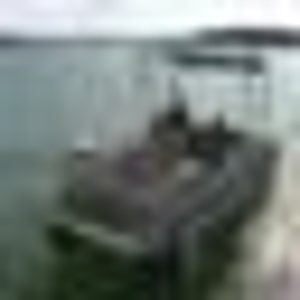

In [47]:
# Display random image in the dataset
random_number = random.randint(0, train_count)
Image.open(str(train_img_array[random_number])).resize((300, 300))

In [55]:
# Check the number of type image extension in the dataset
train_image_types = [
    {"file_type": "jpeg", "count": 0},
    {"file_type": "png", "count": 0},
    {"file_type": "jpg", "count": 0},
    {"file_type": "other", "count": 0},
]

for file_name in train_img_array:
    # Split the file name by the period (.) character
    parts = str(file_name).split(".")
    file_extension = str(parts[-1]).lower()
    found = False
    for counter in range(len(train_image_types)):
        if file_extension == train_image_types[counter]["file_type"]:
            train_image_types[counter]["counter"]=+1
            found = True
            break
        if train_image_types[counter]["file_type"] == "other":
            train_image_types[counter]["counter"]=+1
            break
    
    
print(train_image_types)

[{'file_type': 'jpeg', 'count': 0}, {'file_type': 'png', 'count': 0}, {'file_type': 'jpg', 'count': 0, 'counter': 1}, {'file_type': 'other', 'count': 0}]


### 2.  Data cleaning

<class 'pathlib.PosixPath'>
